In [41]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import glob
import re
import os
import csv
from datetime import datetime

import torch
import torch.nn as nn
import torch.optim as optim
from torch.utils.data import Dataset, DataLoader
from torch.nn.utils.rnn import pad_sequence
from torch.utils.data import TensorDataset
from tqdm import tqdm

from sklearn.preprocessing import StandardScaler
from sklearn.model_selection import train_test_split

In [19]:
data_path_lst = pd.read_csv("/Users/jeongjuhyeon/Desktop/Python/CS230-Project/asdfasdf/Participant_6_results.csv")

In [20]:
all_files = glob.glob("test/*.csv")
datasets = {f: pd.read_csv(f) for f in all_files}


labels = []
examples = []
for fname, df in datasets.items():
    base = os.path.basename(fname).replace(".csv", "")
    # print(f"file name: {base}")
    if len(base.split("_")) ==4:
        _, Condition, Subcondition,Trial  = base.split("_")
        if "pap" in Condition:
            Condition = Condition.replace("pap", "PAP")
        if "camera" in Condition:
            Condition = Condition.replace('camera', 'Camera')
        # print(Condition,Subcondition, Trial)
        row = data_path_lst[
        (data_path_lst["Condition"] == Condition)
        & (data_path_lst["Subcondition"] == Subcondition)
        & (data_path_lst["Trial"] == Trial)]
        
        if row.empty:
            print(f'no data {base}')
        
        else:
            if "Device 0 - Follower 0" in df.columns and "Device 0 - Follower 1" in df.columns:
                example = df[["Device 0 - Follower 0", "Device 0 - Follower 1"]].copy()
                label = row[["Sensor1 Mean", "Sensor2 Mean"]].values.flatten().tolist()
                examples.append(example)
                labels.append(label)

examples = [e.fillna(0) for e in examples]



print(f"Total #examples:  {len(examples)}.")  
print(len(examples), len(labels))
print(len(examples[0]))
print(len(examples[1]))
print(examples[0])
print(labels[0])


no data 3_training_NOhaptics_2
Total #examples:  40.
40 40
828
676
     Device 0 - Follower 0  Device 0 - Follower 1
0                     1124                   1119
1                     1124                   1118
2                     1124                   1118
3                     1123                   1118
4                     1124                   1118
..                     ...                    ...
823                   1017                    973
824                   1027                    977
825                   1015                    979
826                   1018                    972
827                    997                    970

[828 rows x 2 columns]
[1197.76, 1192.59]


In [21]:
examples

[     Device 0 - Follower 0  Device 0 - Follower 1
 0                     1124                   1119
 1                     1124                   1118
 2                     1124                   1118
 3                     1123                   1118
 4                     1124                   1118
 ..                     ...                    ...
 823                   1017                    973
 824                   1027                    977
 825                   1015                    979
 826                   1018                    972
 827                    997                    970
 
 [828 rows x 2 columns],
      Device 0 - Follower 0  Device 0 - Follower 1
 0                     1033                   1034
 1                     1033                   1036
 2                     1037                   1029
 3                     1022                   1027
 4                     1026                   1027
 ..                     ...                    ...
 671

In [2]:
examples = []
labels = []


participant_folders = glob.glob("data/Participant_*")

for folder in participant_folders:
    participant = os.path.basename(folder)  # e.g. "Participant_1"

    
    results_files = glob.glob(os.path.join(folder, f"{participant}_results.csv"))
    if not results_files:
        print(f" No results file found in {participant}")
        continue

    data_path_lst = pd.read_csv(results_files[0])

    
    data_files = glob.glob(os.path.join(folder, "*.csv"))
    data_files = [f for f in data_files if not f.endswith("_results.csv")]

    for fname in data_files:
        base = os.path.basename(fname).replace(".csv", "")

        # ex: "trialA_pap_A_01.csv"
        parts = base.split("_")
        if len(parts) == 4:
            _, Condition, Subcondition, Trial = parts

            
            if "pap" in Condition:
                Condition = Condition.replace("pap", "PAP")
            if "camera" in Condition:
                Condition = Condition.replace("camera", "Camera")

            
            row = data_path_lst[
                (data_path_lst["Condition"] == Condition)
                & (data_path_lst["Subcondition"] == Subcondition)
                & (data_path_lst["Trial"] == Trial)
            ]

            if row.empty:
                print(f"no matching metadata: {participant}/{base}")
            

            else:
            
                df = pd.read_csv(fname)
                if "Device 0 - Follower 0" in df.columns and "Device 0 - Follower 1" in df.columns:
                    example = df[["Device 0 - Follower 0", "Device 0 - Follower 1"]].copy()
                    label = row[["Sensor1 Mean", "Sensor2 Mean"]].values.flatten().tolist()
                    examples.append(example.fillna(0))
                    labels.append(label)

print(f"Total examples collected before preprocessing: {len(examples)}")
print(f"Total labels collected before preprocessing: {len(labels)}")



# delete ['x','x']
valid_examples = []
valid_labels = []

for e, l in zip(examples, labels):
    if any(str(x).lower() == 'x' for x in l):
        continue  
    valid_examples.append(e)
    valid_labels.append(l)

print(f"Total examples collected after preprocessing: {len(valid_examples)}")
print(f"Total labels collected after preprocessing: {len(valid_labels)}")

Total examples collected before preprocessing: 120
Total labels collected before preprocessing: 120
Total examples collected after preprocessing: 95
Total labels collected after preprocessing: 95


In [6]:
# train+temp / test  : 85/15 
ex_train, ex_temp, y_train, y_temp = train_test_split(
    valid_examples, valid_labels, test_size=0.15, random_state=42
)
# train / dev  : 0.85 * 0.176 = 0.15 : 70/15/15
ex_train, ex_dev, y_train, y_dev = train_test_split(
    ex_train, y_train, test_size=0.176, random_state=42
)

print(f"Train: {len(ex_train)}, Dev: {len(ex_dev)}, Test: {len(ex_temp)}")


Train: 65, Dev: 15, Test: 15


In [7]:
def normalize_examples(example_list, scaler=None):
    scaled_tensors = []
    if scaler is None:
        scaler = StandardScaler()
        for e in example_list:
            scaled = scaler.fit_transform(e.values.astype(float))
            scaled_tensors.append(torch.tensor(scaled, dtype=torch.float32))
        return scaled_tensors, scaler
    else:
        for e in example_list:
            scaled = scaler.transform(e.values.astype(float))
            scaled_tensors.append(torch.tensor(scaled, dtype=torch.float32))
        return scaled_tensors

def pad_tensor_list(tensor_list):
    seq_lengths = torch.tensor([x.size(0) for x in tensor_list])
    padded = pad_sequence(tensor_list, batch_first=True, padding_value=0.0)
    return padded, seq_lengths

In [27]:
# example normalization
train_examples, ex_scaler = normalize_examples(ex_train)
dev_examples = normalize_examples(ex_dev, ex_scaler)
test_examples = normalize_examples(ex_temp, ex_scaler)

# label normalization (train 기준으로 fit)
scaler_y = StandardScaler()
y_train_arr = np.array(y_train, dtype=float)
y_dev_arr = np.array(y_dev, dtype=float)
y_test_arr = np.array(y_temp, dtype=float)

scaler_y.fit(y_train_arr)
y_train_scaled = torch.tensor(scaler_y.transform(y_train_arr), dtype=torch.float32)
y_dev_scaled = torch.tensor(scaler_y.transform(y_dev_arr), dtype=torch.float32)
y_test_scaled = torch.tensor(scaler_y.transform(y_test_arr), dtype=torch.float32)

padded_train, len_train = pad_tensor_list(train_examples)
padded_dev, len_dev = pad_tensor_list(dev_examples)
padded_test, len_test = pad_tensor_list(test_examples)

train_dataset = TensorDataset(padded_train, y_train_scaled, len_train)
dev_dataset   = TensorDataset(padded_dev, y_dev_scaled, len_dev)
test_dataset  = TensorDataset(padded_test, y_test_scaled, len_test)

batch_size = 8
train_loader = DataLoader(train_dataset, batch_size=batch_size, shuffle=True)
dev_loader   = DataLoader(dev_dataset, batch_size=batch_size, shuffle=False)
test_loader  = DataLoader(test_dataset, batch_size=batch_size, shuffle=False)

print("Dataset & Loader Shapes Summary")
print("----------------------------------")
print(f"Train set ->  Examples: {len(train_dataset)},  Labels: {y_train_scaled.shape},  "
      f"Batches: {len(train_loader)} (batch_size={batch_size})")
print(f"Dev set   ->  Examples: {len(dev_dataset)},   Labels: {y_dev_scaled.shape},  "
      f"Batches: {len(dev_loader)} (batch_size={batch_size})")
print(f"Test set  ->  Examples: {len(test_dataset)},  Labels: {y_test_scaled.shape},  "
      f"Batches: {len(test_loader)} (batch_size={batch_size})")
print("----------------------------------")
print(f"Train tensor shape: {padded_train.shape}")
print(f"Dev tensor shape:   {padded_dev.shape}")
print(f"Test tensor shape:  {padded_test.shape}")



Dataset & Loader Shapes Summary
----------------------------------
Train set ->  Examples: 65,  Labels: torch.Size([65, 2]),  Batches: 9 (batch_size=8)
Dev set   ->  Examples: 15,   Labels: torch.Size([15, 2]),  Batches: 2 (batch_size=8)
Test set  ->  Examples: 15,  Labels: torch.Size([15, 2]),  Batches: 2 (batch_size=8)
----------------------------------
Train tensor shape: torch.Size([65, 2499, 2])
Dev tensor shape:   torch.Size([15, 1459, 2])
Test tensor shape:  torch.Size([15, 1882, 2])


In [33]:
if torch.backends.mps.is_available():      # M1/M2 GPU
    device = torch.device("mps")
elif torch.cuda.is_available():            # NVIDIA GPU
    device = torch.device("cuda")
else:                                      # CPU fallback
    device = torch.device("cpu")

print(f" Using device: {device}")

 Using device: mps


In [46]:
class PressureRNN(nn.Module):
    def __init__(self, input_dim=2, hidden_dim=64, output_dim=2, num_layers=3):
        super().__init__()
        self.lstm = nn.LSTM(input_dim, hidden_dim, num_layers, dropout = 0.3, batch_first=True)
        self.fc = nn.Sequential(
            nn.Linear(hidden_dim, 64),
            nn.ReLU(),
            nn.Dropout(0.3),
            nn.Linear(64,2)
        )

    def forward(self, x, lengths):
        # pack: variable length 처리
        packed = nn.utils.rnn.pack_padded_sequence(x, lengths.cpu(), 
                                                   batch_first=True, 
                                                   enforce_sorted=False)
        packed_out, (h_n, c_n) = self.lstm(packed)
        # 마지막 hidden state만 사용
        out = self.fc(h_n[-1])
        return out


In [ ]:
model = PressureRNN().to(device)
criterion = nn.MSELoss()
optimizer = torch.optim.Adam(model.parameters(), lr=1e-3)

n_epochs = 10

In [39]:

train_losses = []
dev_losses = []
for epoch in range(n_epochs):
    model.train()
    total_train_loss = 0.0
    # --- Training ---
    progress = tqdm(train_loader, desc=f"Epoch {epoch+1}/{n_epochs}", leave=False)
    for batch_x, batch_y, batch_len in progress:
        batch_x, batch_y = batch_x.to(device), batch_y.to(device)

        optimizer.zero_grad()
        outputs = model(batch_x, batch_len)
        loss = criterion(outputs, batch_y)
        loss.backward()
        torch.nn.utils.clip_grad_norm_(model.parameters(), max_norm=1.0)
        optimizer.step()

        total_train_loss += loss.item() * batch_x.size(0)
        progress.set_postfix({"batch_loss": f"{loss.item():.4f}"})

    avg_train_loss = total_train_loss / len(train_loader.dataset)
    train_losses.append(avg_train_loss)

    # --- Validation ---
    model.eval()
    total_dev_loss = 0.0
    with torch.no_grad():
        for batch_x, batch_y, batch_len in dev_loader:
            batch_x, batch_y = batch_x.to(device), batch_y.to(device)
            dev_outputs = model(batch_x, batch_len)
            dev_loss = criterion(dev_outputs, batch_y)
            total_dev_loss += dev_loss.item() * batch_x.size(0)
    avg_dev_loss = total_dev_loss / len(dev_loader.dataset)
    dev_losses.append(avg_dev_loss)

    if (epoch + 1) % 5 == 0 or epoch == 0:
        tqdm.write(f"Epoch [{epoch+1:>2}/{n_epochs}] | Train Loss: {avg_train_loss:.6f} | Dev Loss: {avg_dev_loss:.6f}")

print("\n Training finished!")
print(f"Final Train Loss: {train_losses[-1]:.6f}")
print(f"Final Dev Loss:   {dev_losses[-1]:.6f}")


Epoch [ 1/50] | Train Loss: 1.007637 | Dev Loss: 0.922976


Epoch [ 5/50] | Train Loss: 0.996433 | Dev Loss: 0.927178


Epoch [10/50] | Train Loss: 0.939075 | Dev Loss: 0.878651


Epoch [15/50] | Train Loss: 0.806261 | Dev Loss: 0.875207


Epoch [20/50] | Train Loss: 0.784454 | Dev Loss: 0.899510


Epoch [25/50] | Train Loss: 0.712148 | Dev Loss: 1.317076


Epoch [30/50] | Train Loss: 0.707924 | Dev Loss: 0.958621


Epoch [35/50] | Train Loss: 0.577361 | Dev Loss: 1.417685


Epoch [40/50] | Train Loss: 0.450483 | Dev Loss: 1.701829


Epoch [45/50] | Train Loss: 0.405837 | Dev Loss: 1.388397


Epoch [50/50] | Train Loss: 0.418693 | Dev Loss: 1.311672

 Training finished!
Final Train Loss: 0.418693
Final Dev Loss:   1.311672


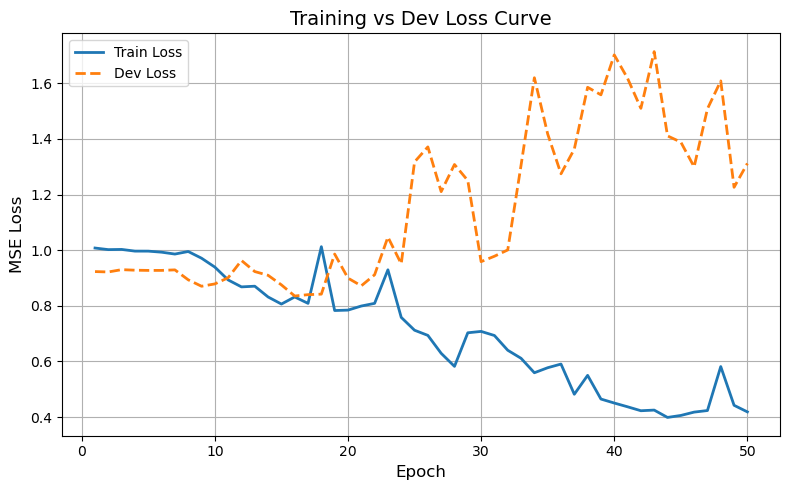

In [43]:
plt.figure(figsize=(8,5))
plt.plot(range(1, n_epochs+1), train_losses, label='Train Loss', linewidth=2)
plt.plot(range(1, n_epochs+1), dev_losses, label='Dev Loss', linewidth=2, linestyle='--')
plt.xlabel('Epoch', fontsize=12)
plt.ylabel('MSE Loss', fontsize=12)
plt.title('Training vs Dev Loss Curve', fontsize=14)
plt.legend()
plt.grid(True)
plt.tight_layout()
plt.show()

In [61]:

from datetime import datetime


log_path = os.path.join("results", "experiment_logs.csv")



def log_experiment(params):
    file_exists = os.path.exists(log_path)
    with open(log_path, mode='a', newline='') as f:
        writer = csv.DictWriter(f, fieldnames=params.keys())
        if not file_exists:
            writer.writeheader()
        writer.writerow(params)

def save_loss_plot(train_losses, dev_losses, title, filename):
    plt.figure(figsize=(8,5))
    plt.plot(train_losses, label="Train Loss", linewidth=2)
    plt.plot(dev_losses, label="Dev Loss", linewidth=2)
    plt.xlabel("Epoch")
    plt.ylabel("MSE Loss")
    plt.title(title)
    plt.legend()
    plt.grid(True, linestyle='--', alpha=0.6)
    plt.tight_layout()
    plt.savefig(filename, dpi=300)
    plt.close()
    print(f" Saved loss plot: {filename}")

def summarize_model(model: torch.nn.Module):
    lines = []
    for name, layer in model.named_children():
        layer_str = str(layer).replace("\n", "")
        lines.append(f"{name}: {layer_str}")
    return " → ".join(lines)


timestamp = datetime.now().strftime("%Y-%m-%d_%H-%M-%S")

params = {
    "timestamp": timestamp,
    "architecture": summarize_model(model),
    "hidden_dim": model.lstm.hidden_size,
    "num_layers": model.lstm.num_layers,
    "dropout": 0.3,
    "learning_rate": 1e-3,
    "batch_size": 8,
    "n_epochs": 50,
    "train_size": len(train_loader.dataset),
    "dev_size": len(dev_loader.dataset),
    "final_train_loss": round(train_losses[-1], 6),
    "final_dev_loss": round(dev_losses[-1], 6),
    "best_dev_loss": round(min(dev_losses), 6),
    "best_epoch": int(dev_losses.index(min(dev_losses)) + 1),
    "device": str(device),
    "optimizer": "Adam",
    "scheduler": "ReduceLROnPlateau",
    "notes": " "
}

plot_filename = os.path.join("results", "plots", f"loss_curve_{timestamp}.png")


save_loss_plot(
    train_losses, 
    dev_losses, 
    title=f"Training vs Dev Loss ({timestamp})",
    filename=plot_filename
)

log_experiment(params)
print(f"Experiment logged to {log_path}")


 Saved loss plot: results/plots/loss_curve_2025-11-07_02-56-56.png
Experiment logged to results/experiment_logs.csv
